In [1]:
import inspect
import itertools
from typing import Type, Union

import ipywidgets
import sympy
from IPython.display import display
from sympy import *

In [2]:
x, y, z = sympy.symbols("x y z", real=True)
r = sympy.symbols("r", real=True, positive=True)
p = Matrix([x, y, z])

In [3]:
def Clip(x, lower, upper):
    return sympy.Max(lower, sympy.Min(x, upper))

In [4]:
def Gradient(expr: sympy.Expr):
    "1,2,3D gradient"
    return sympy.Matrix(
        [
            [
                expr.diff(v)
                for v in sorted(expr.free_symbols.intersection({x, y, z}), key=str)
            ]
        ]
    )

In [5]:
def Translate(sdf, xyz):
    return sdf.subs({var: var - offset for var, offset in zip((x, y, z), xyz)})

In [6]:
def Sphere(r):
    return sympy.sqrt(x**2 + y**2 + z**2) - r

In [7]:
def Length(p):
    return sqrt(p.dot(p))

In [8]:
def Capsule(a, b, r):
    pa = p - Matrix(a)
    ba = Matrix(b) - Matrix(a)
    h = Clip(pa.dot(ba) / ba.dot(ba), 0, 1)
    return Length(pa - ba * h) - r

In [9]:
def Cylinder(r):
    return sympy.sqrt(x**2 + y**2) - r

In [10]:
def Cylinder2(r):
    return sympy.sqrt(z**2 + y**2) - r

In [38]:
def Union(*sdfs, k=0):
    if k > 0:
        sdf1, sdf2 = sdfs
        h = Clip(1 / 2 + 1 / 2 * (sdf1 + sdf2) / k, 0, 1)
        return sdf2 * h - sdf1 * (1 - h) + k * h * (1 - h)
    else:
        return sympy.Min(*sdfs)

In [12]:
def Intersection(*sdfs):
    return sympy.Max(*sdfs)

In [13]:
def Lambdify(sdf):
    return sympy.lambdify((x, y, z), sdf)

In [14]:
Sphere(10)

sqrt(x**2 + y**2 + z**2) - 10

In [15]:
Cylinder(5)

sqrt(x**2 + y**2) - 5

In [16]:
Union(Sphere(10), Cylinder(5))

Min(sqrt(x**2 + y**2) - 5, sqrt(x**2 + y**2 + z**2) - 10)

# Rendering Process

When rendering, we want to create a rectangular image where we need to fill the color value of each pixel. This is how (I think) it works:

- Imagine we have a rectangular **grid-like siv** with as many row and column holes as our output pixel plane.
- We take this siv and **look through it onto our model**. From this a couple of values need quantification:
  - How large is our siv? Or in other terms: What (horizontal?) field of view angle does it cover? → `camera_fov`
  - How far away is our face from the siv? → `camera_distance`
- When the siv is in place, we need to **look through each hole** and determine what color we see through it
- To determine the color we see through a given hole, we first need the ray vector from our eye (camera) to that hole.
  - We start from our camera position $\vec v_\mathrm{campos}$
  - We walk `camera_distance` $d_\mathrm{camera}$ away from it in the direction of the view vector $\vec v_\mathrm{view}$:
    - $\vec v_\mathrm{campos} + d_\mathrm{camera} \cdot \vec v_\mathrm{view}$
  - We then hit the *center of the siv*. From there, we need to move on the siv-plane to reach our target siv hole.
  - Each hole has an equal width and height $\Delta s_\mathrm{pixel}$.
  - The triangle camera-gridcenter-gridside gives the following formula:

In [17]:
α_fov, n_cols, Δs_pixel, d_camera = sympy.symbols(
    "α_fov n_cols Δs_pixel d_camera", real=True, positive=True
)
display(eq := Eq(tan(α_fov / 2), (n_cols / 2 * Δs_pixel) / d_camera))
display(Δs_pixel_eq := Eq(Δs_pixel, solve(eq, Δs_pixel)[0]))
Δs_pixel_func = lambdify(list(Δs_pixel_eq.rhs.free_symbols), Δs_pixel_eq.rhs)
print(inspect.getsource(Δs_pixel_func))

Eq(tan(α_fov/2), n_cols*Δs_pixel/(2*d_camera))

Eq(Δs_pixel, 2*d_camera*tan(α_fov/2)/n_cols)

def _lambdifygenerated(n_cols, d_camera, α_fov):
    return 2*d_camera*tan((1/2)*α_fov)/n_cols



- But in which direction do we go this $\Delta s_\mathrm{pixel}$ to reach our hole? Somehow ”along the grid” but where is that 🤔? 
- ⇒ We need to find the two base vectors (let's call them $\vec e$ and $\vec f$) that ”make up” the grid plane so we can walk along them.

In [18]:
e_x, e_y, e_z, c_x, c_y, c_z, f_x, f_y = sympy.symbols(
    "e_x e_y e_z c_x c_y c_z f_x f_y", real=True
)
f_z = sympy.symbols("f_z", real=True, positive=True)
c = Matrix([c_x, c_y, c_z])  # camera view vector
e = Matrix([e_x, e_y, e_z])
f = Matrix([f_x, f_y, f_z])

- $\vec e$ and $\vec f$ are constrained by the following conditions:
  1. $\vec e$ and $\vec f$ are orthogonal to the camera view vector \vec v_\mathrm{view}
  2. $\vec e$ and $\vec f$ are orthogonal to each other
  3. Let's not „tilt our head”, so $\vec e$ is orthogonal the the $\vec z$ vertical axis

In [19]:
solutions = solve(
    [
        # camera vector is orthogonal to both
        Eq(f.cross(e), c),
        # e and f are orthogonal
        Eq(e.dot(f), 0),
        # e is parallel to xy plane
        Eq(e.dot(Matrix([0, 0, 1])), 0),
        # unit vector e, somehow necessary so f_z comes out as well 🤷
        Eq(sqrt(e.dot(e)), 1),
    ],
    (v := (e_x, e_y, e_z, f_x, f_y, f_z)),
)
print(f"{len(solutions) = }")
solution = dict(zip(v, solutions[0]))
solution

len(solutions) = 1


{e_x: c_y/sqrt(c_x**2 + c_y**2),
 e_y: -c_x/sqrt(c_x**2 + c_y**2),
 e_z: 0,
 f_x: -c_x*c_z/sqrt(c_x**2 + c_y**2),
 f_y: -c_y*c_z/sqrt(c_x**2 + c_y**2),
 f_z: sqrt(c_x**2 + c_y**2)}

In [20]:
Matrix(e.subs(solution))

Matrix([
[ c_y/sqrt(c_x**2 + c_y**2)],
[-c_x/sqrt(c_x**2 + c_y**2)],
[                         0]])

In [21]:
Matrix(f.subs(solution))

Matrix([
[-c_x*c_z/sqrt(c_x**2 + c_y**2)],
[-c_y*c_z/sqrt(c_x**2 + c_y**2)],
[         sqrt(c_x**2 + c_y**2)]])

- For some reason, it seems to be a problem to have $\vec v_\mathrm{view}$ look completely up or down 🤷
- Anyway, we apparently found the plane base vectors for our grid siv, so let's sanity-check if it makes sense:

In [22]:
import operator


def VerboseReduction(operation, *x):
    return Eq(
        UnevaluatedExpr(functools.reduce(operation, map(UnevaluatedExpr, x))),
        UnevaluatedExpr(functools.reduce(operation, x)),
    )


def normalize(vector):
    return vector / sympy.sqrt(vector.dot(vector))

In [23]:
display(
    Eq(
        UnevaluatedExpr(sympy.symbols("v_view")),
        UnevaluatedExpr(c.subs(c_example := {c_x: 2, c_y: -1, c_z: 0})),
    )
)
display(
    VerboseReduction(
        operator.mul,
        Matrix([normalize(e.subs(solution).T), normalize(f.subs(solution).T)])
        .T.subs(c_example)
        .evalf(2),
        Matrix([[0, 0], [1, 2], [-2, 1], [2, -3]]).T,
    )
)
M_sivbase_unnormalized = Matrix([e.subs(solution).T, f.subs(solution).T]).T
M_sivbase_unnormalized_func = lambdify(
    sorted(M_sivbase_unnormalized.free_symbols, key=str), M_sivbase_unnormalized
)
print(inspect.getsource(M_sivbase_unnormalized_func))

Eq(v_view, Matrix([
[ 2],
[-1],
[ 0]]))

Eq(Matrix([
[-0.45,   0],
[-0.89,   0],
[    0, 1.0]])*Matrix([
[0, 1, -2,  2],
[0, 2,  1, -3]]), Matrix([
[0, -0.45, 0.89, -0.89],
[0, -0.89,  1.8,  -1.8],
[0,   2.0,  1.0,  -3.0]]))

def _lambdifygenerated(c_x, c_y, c_z):
    return array([[c_y/sqrt(c_x**2 + c_y**2), -c_x*c_z/sqrt(c_x**2 + c_y**2)], [-c_x/sqrt(c_x**2 + c_y**2), -c_y*c_z/sqrt(c_x**2 + c_y**2)], [0, sqrt(c_x**2 + c_y**2)]])



- (We needed to normalize the base vectors first, at least $\vec f$)
- The columns of the first matrix (let's call it $\vec M_\mathrm{sivbase}$) are the siv plane base vectors. They are orthogonal to the view vector and to each other, that's a good sign.
- The columns of the second matrix (let's call it $\vec M_\mathrm{holesonsiv}$) are the vectors in ”siv-plane-coordinates”, so $n_\mathrm{rows/cols} \cdot \Delta s_\mathrm{pixel}$
- The columns of the resulting matrix (let's call it $\vec M_\mathrm{holesinworld}$) are the resulting coordinates of the siv hole of interest in 3D world coordinates.
- It makes sense, that the zero-vector ends up at zero again
- The other values makes sense as well upon closer inspection (interpret the $\vec v_\mathrm{view}$ as *pointing to the origin*)

- Now that we can walk along the siv plane we can finish our formula from above to get from our camera to the hole position we're looking at:
  - to siv center: $\vec v_\mathrm{campos} + d_\mathrm{camera} \cdot \vec v_\mathrm{view}$
  - to target hole: $\vec v_\mathrm{campos} + d_\mathrm{camera} \cdot \vec v_\mathrm{view} + \vec M_\mathrm{sivbase} \cdot \vec v_\mathrm{holeonsiv}$

In [24]:
np.set_printoptions(precision=1, linewidth=100)

In [25]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pint

units = pint.UnitRegistry()
%matplotlib widget

In [26]:
import rich
from rich.progress import Progress

In [27]:
Capsule((1, 0, 0), (0, 2, 0), 5)

sqrt(z**2 + (y - 2*Max(0, Min(1, -x/5 + 2*y/5 + 1/5)))**2 + (x + Max(0, Min(1, -x/5 + 2*y/5 + 1/5)) - 1)**2) - 5

In [28]:
Translate(Capsule((0, 0, 0), (0, 0, 20), 3), (5, 5, 0))

sqrt((x - 5)**2 + (y - 5)**2 + (z - 20*Max(0, Min(1, z/20)))**2) - 3

In [29]:
@dataclass
class SDFRenderer:
    width: int = 200
    height: int = 200

    def render(
        self,
        *sdf,
        camera_location=np.array((20, 20, 10)),
        camera_fov=units("90°"),
        camera_distance=0.5,
        light_direction=[0, -1, -1],
        light_brightness=0.9,
        dark_brightness=0.1,
        background_brightness=0.5,
        lambdify_gradient=True,
        camera_view_vector=None,
        show=True,
    ):
        sdf = Union(*sdf)
        if camera_view_vector is None:  # look at origin by default
            camera_view_vector = -camera_location
        camera_view_vector = camera_view_vector / np.linalg.norm(
            camera_view_vector
        )  # normalize camera view vector
        light_direction = np.array(light_direction) / np.linalg.norm(light_direction)
        output = np.full((self.height, self.width), np.nan)  # start with empty output

        # create the siv base matrix to convert between 2D-output coordinates and world coordinates
        # and normalize it
        M_sivbase = np.apply_along_axis(
            lambda x: x / np.linalg.norm(x),
            axis=0,
            arr=M_sivbase_unnormalized_func(*camera_view_vector),
        )
        # print(f"M_sivbase = \n{M_sivbase}")

        # determine how large a pixel is in world coordinates
        Δs_pixel = Δs_pixel_func(
            α_fov=camera_fov, d_camera=camera_distance, n_cols=self.width
        ).m
        # print(f"{Δs_pixel = }")

        # now make matrices for pixel row and col
        row, col = np.mgrid[: self.height, : self.width]
        # center it
        row = row - row.shape[0] / 2
        col = col - col.shape[1] / 2
        row_col_on_siv = np.stack([row, col])
        # print(f"row_col_on_siv = \n{row_col_on_siv}")
        pos_on_siv = row_col_on_siv * Δs_pixel  # scale by pixel size
        # print(f"pos_on_siv = \n{pos_on_siv}")

        # reshape it to a 2xN matrix for multiplication with the siv base matrix
        pos_on_siv_reshaped = pos_on_siv.reshape((2, np.product(pos_on_siv.shape) // 2))
        # transform siv hole grid points to world coordinate offsets
        pos_on_siv_world_offset = M_sivbase @ pos_on_siv_reshaped
        # print(f"pos_on_siv_world_offset = \n{pos_on_siv_world_offset}")

        # siv_center_world = camera_location + camera_view_vector * camera_distance
        # print(f"{siv_center_world = }")

        # columns of ray vector are directions from camera location
        # to the pixel/siv hole we're looking towards
        ray_vector = (
            np.repeat(
                [camera_view_vector * camera_distance],
                pos_on_siv_world_offset.shape[1],
                axis=0,
            ).T
            + pos_on_siv_world_offset
        )
        # print(f"ray_vector = \n{ray_vector}")

        pixelbrightness = []
        MAXITER = 50
        MAXDISTANCE = 1000
        MINDISTANCE = 0.1

        print("Lambdify SDF...")
        sdf_func = sympy.lambdify((x, y, z), sdf)
        print(inspect.getsource(sdf_func))
        print("Gradient...")
        sdf_gradient = Gradient(sdf)
        display(sdf_gradient)
        if lambdify_gradient:
            print("Lambdify Gradient...")
            sdf_gradient_func = Lambdify(sdf_gradient)
        else:
            sdf_gradient_func = lambda _x, _y, _z: np.array(
                sdf_gradient.subs({x: _x, y: _y, z: _z}).evalf()
            ).astype(float)
        print(inspect.getsource(sdf_gradient_func))
        print(f"{sdf_gradient_func(1,2,3) = !r}")

        def ray_march(start, direction):
            traveled = 0
            closest_distance_along_ray = np.inf
            closest_distance = np.inf
            for n in itertools.count(start=1):
                if traveled > MAXDISTANCE:
                    return (
                        background_brightness  # this far away there's probably nothing
                    )
                if n > MAXITER:
                    # return closest_distance_along_ray
                    return background_brightness
                point = start + traveled * direction
                closest_distance = sdf_func(*point)
                if closest_distance < MINDISTANCE:
                    gradient = np.array(sdf_gradient_func(*point)).flatten()
                    gradient = gradient / np.linalg.norm(gradient)
                    # print(gradient)
                    dot = np.dot(gradient, light_direction)
                    # print(f"{gradient = },{direction = }, {dot = }")
                    return np.clip(np.abs(dot), dark_brightness, light_brightness)
                    # return closest_distance  # hit the surface!
                traveled += closest_distance
                closest_distance_along_ray = min(
                    closest_distance, closest_distance_along_ray
                )
            return closest_distance_along_ray

        for direction in rich.progress.track(ray_vector.T):
            brightness = ray_march(start=camera_location, direction=direction)
            pixelbrightness.append(brightness)

        output = np.array(pixelbrightness).reshape(output.shape)

        if show:
            fig, ax = plt.subplots()
            m = ax.imshow(output, origin="lower", cmap="gray", vmin=0, vmax=1)
            fig.colorbar(m)

        return output

In [30]:
np.array(Gradient(Sphere(1)).subs({x: 1, y: 2, z: 3}).evalf()).astype(float)

array([[0.3, 0.5, 0.8]])

Lambdify SDF...
def _lambdifygenerated(x, y, z):
    return -(1 - amax((0,amin((1,1.0*sqrt(x**2 + y**2 + z**2) + 1.0*sqrt((x - 5)**2 + (z - 5*amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0))**2 + (y + amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0) - 6)**2) - 7.5), axis=0)), axis=0))*(sqrt((x - 5)**2 + (z - 5*amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0))**2 + (y + amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0) - 6)**2) - 3) + 0.5*(1 - amax((0,amin((1,1.0*sqrt(x**2 + y**2 + z**2) + 1.0*sqrt((x - 5)**2 + (z - 5*amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0))**2 + (y + amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0) - 6)**2) - 7.5), axis=0)), axis=0))*amax((0,amin((1,1.0*sqrt(x**2 + y**2 + z**2) + 1.0*sqrt((x - 5)**2 + (z - 5*amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0))**2 + (y + amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0) - 6)**2) - 7.5), axis=0)), axis=0) + (sqrt(

Matrix([[x*Max(0, Min(1, 1.0*sqrt(x**2 + y**2 + z**2) + 1.0*sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) - 7.5))/sqrt(x**2 + y**2 + z**2) - (1 - Max(0, Min(1, 1.0*sqrt(x**2 + y**2 + z**2) + 1.0*sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) - 7.5)))*(x - 5)/sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) + 0.5*(1 - Max(0, Min(1, 1.0*sqrt(x**2 + y**2 + z**2) + 1.0*sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) - 7.5)))*(1.0*x/sqrt(x**2 + y**2 + z**2) + 1.0*(x - 5)/sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2))*Heaviside(-1.0*sqrt(x**2 + y**2 + z**2) - 1.0*sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 

Output()

            sdf_gradient_func = lambda _x, _y, _z: np.array(
                sdf_gradient.subs({x: _x, y: _y, z: _z}).evalf()
            ).astype(float)

sdf_gradient_func(1,2,3) = array([[0.3, 0.5, 0.8]])


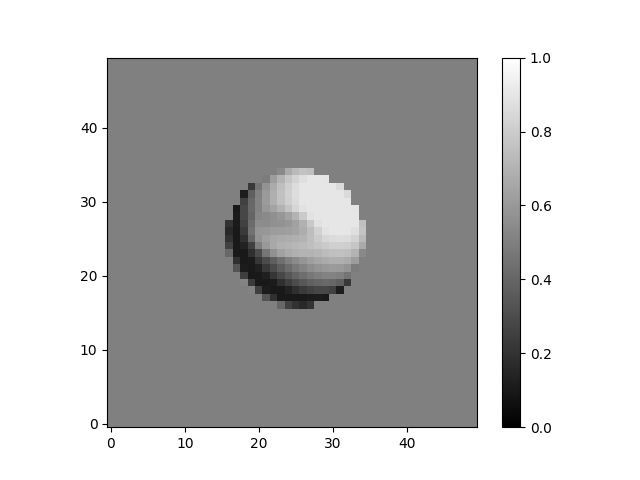

In [40]:
SDFRenderer(width=50, height=50).render(
    Union(Translate(Capsule((0, 1, 0), (0, 0, 5), 3), (5, 5, 0)), Sphere(5), k=0.5),
    camera_distance=0.5,
    camera_fov=units("50°"),
    dark_brightness=0.1,
    light_brightness=0.9,
    background_brightness=0.5,
    lambdify_gradient=False,
);

In [ ]:
SDFRenderer(width=50, height=50).render(
    Sphere(10),
    Cylinder(5),
    Cylinder2(2),
    Translate(Capsule((0, 1, 0), (0, 0, 5), 3), (5, 5, 0)),
    lambdify_gradient=False,
);

Lambdify SDF...
def _lambdifygenerated(x, y, z):
    return amin((sqrt(x**2 + y**2) - 5,sqrt(y**2 + z**2) - 2,sqrt(x**2 + y**2 + z**2) - 10,sqrt((x - 5)**2 + (z - 5*amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0))**2 + (y + amax((0,amin((1,-1/26*y + (5/26)*z + 3/13), axis=0)), axis=0) - 6)**2) - 3), axis=0)

Gradient...


Matrix([[x*Heaviside(-sqrt(x**2 + y**2 + z**2) + Min(sqrt(x**2 + y**2) - 5, sqrt(y**2 + z**2) - 2, sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) - 3) + 10)/sqrt(x**2 + y**2 + z**2) + x*Heaviside(-sqrt(x**2 + y**2) + Min(sqrt(y**2 + z**2) - 2, sqrt(x**2 + y**2 + z**2) - 10, sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) - 3) + 5)/sqrt(x**2 + y**2) + (x - 5)*Heaviside(-sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2) + Min(sqrt(x**2 + y**2) - 5, sqrt(y**2 + z**2) - 2, sqrt(x**2 + y**2 + z**2) - 10) + 3)/sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13)))**2 + (y + Max(0, Min(1, -y/26 + 5*z/26 + 3/13)) - 6)**2), y*Heaviside(-sqrt(x**2 + y**2 + z**2) + Min(sqrt(x**2 + y**2) - 5, sqrt(y**2 + z**2) - 2, sqrt((x - 5)**2 + (z - 5*Max(0, Min(1, -y/26 + 5*z/26 + 3/13

            sdf_gradient_func = lambda _x, _y, _z: np.array(
                sdf_gradient.subs({x: _x, y: _y, z: _z}).evalf()
            ).astype(float)



Output()

sdf_gradient_func(1,2,3) = array([[0.3, 0.5, 0.8]])
